In [1]:
import sys
sys.path.insert(0, '../')

import pandas as pd
from preprocess import Audio_Processor
import data_utils as du
from sklearn import metrics
import time

from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from classification_plots import plot_confusion_matrix, plot_learning_curve
import matplotlib.pyplot as plt
import os
from collections import Counter
import numpy as np

Using TensorFlow backend.


Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Able to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="0"

SR = 16000
blocksize = int(SR/2)
overlap = int(SR/4)

In [3]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [4]:
audio_dir = '../../ESC-50/audio/'

In [5]:
path_to_db='../../ESC-50/'
ps = Audio_Processor(path_to_db + 'audio/')

# Load Dataset
Here we load the csv that describes each file in the dataset. We add a high level category that is defined in the ESC-50 documentation. This we realize is anthetical to true training, it is a stopgap for when we use NLP to classify tags into these categories.

In [6]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')
classes = [None] * 50

In [7]:
h_classes = ['Human & Animal', 'Interacting Materials']
mapping = {'dog': 0,'rooster': 0,'pig': 0,'cow': 0,'frog': 0,'cat': 0,'hen': 0,
            'insects': 0,'sheep': 0,'crow': 0,'rain': 1,'sea_waves': 1,'crackling_fire': 1,
            'crickets': 0,'chirping_birds': 0,'water_drops': 1,'wind': 1,'pouring_water': 1,
            'toilet_flush': 1,'thunderstorm': 1,'crying_baby': 0,'sneezing': 0,'clapping': 0,
            'breathing': 0,'coughing': 0,'footsteps': 1,'laughing': 0,'brushing_teeth': 1,
            'snoring': 0,'drinking_sipping': 1,'door_wood_knock': 1,'mouse_click': 1,
            'keyboard_typing': 1,'door_wood_creaks': 1,'can_opening': 1,'washing_machine': 1,
            'vacuum_cleaner': 1,'clock_alarm': 1,'clock_tick': 1,'glass_breaking':1,'helicopter': 1,
            'chainsaw': 1,'siren': 1,'car_horn': 1,'engine': 1,'train': 1,'church_bells': 1,
            'airplane': 1,'fireworks': 1,'hand_saw': 1,
            }

In [8]:
dataset['h_target'] = None
for index, row in dataset.iterrows():
    target = row['target']
    classes[target] = row['category']
    dataset.loc[index, 'h_target'] = mapping[row['category']]

In [9]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take,h_target
0,1-100032-A-0.wav,1,0,dog,True,100032,A,0
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,0
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1


## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [10]:
df = ps.preprocess_fold(dataset,
                        kind='mfcc',
                        blocksize=blocksize,
                        overlap=overlap,
                        folds=5,
                        feature_bag=False
                       )

In [11]:
df.describe()

,target,h_target,fold
count,2000.000000,2000.00000,2000.000000
mean,24.500000,0.64000,3.000000
std,14.434479,0.48012,1.414567
min,0.000000,0.00000,1.000000
25%,12.000000,0.00000,2.000000
50%,24.500000,1.00000,3.000000
75%,37.000000,1.00000,4.000000
max,49.000000,1.00000,5.000000


In [12]:
train = ps.bag_of_features(df[df.fold != 1].reset_index())
train.head()

,mfcc_2_std,mfcc_2_mean,mfcc_2_noise,mfcc_3_std,mfcc_3_mean,mfcc_3_noise,mfcc_4_std,mfcc_4_mean,mfcc_4_noise,mfcc_5_std,...,sflat_noise,sroll_std,sroll_mean,sroll_noise,rmse_std,rmse_mean,rmse_noise,h_target,target,fold
0,52.009557,4.327045,5.696827,6.522973,3.426770,9.314700,8.897445,1.613144,3.654356,6.125930,...,-0.430331,0.430331,29.442891,33.986595,7.463287,129.495423,54.772801,0,0,2
1,88.404377,82.645071,55.548627,51.936489,32.090942,23.103625,23.082517,18.536499,16.418501,15.469806,...,0.475820,-0.102448,15.695233,20.199985,3.943083,20.152053,1.728330,0,0,2
2,86.987377,78.083572,51.433488,51.561430,33.107803,31.318922,21.869279,15.681414,22.181496,16.827397,...,0.254841,0.158864,14.345672,19.755847,3.758124,17.172734,1.683485,0,0,2
3,80.670230,68.750011,19.582458,23.847321,18.158782,20.392203,9.204180,11.268402,12.634953,12.072391,...,0.278538,0.105655,25.330133,34.365584,4.991139,27.321271,10.232799,0,0,2
4,81.355627,60.950895,35.026463,48.047609,53.739915,42.014673,48.515288,36.766431,53.463175,52.233060,...,0.425719,0.243835,12.205491,13.338520,5.419358,15.416913,3.034387,0,14,3


In [13]:
test = ps.bag_of_features(df[df.fold == 1].reset_index())
test.head()

,mfcc_2_std,mfcc_2_mean,mfcc_2_noise,mfcc_3_std,mfcc_3_mean,mfcc_3_noise,mfcc_4_std,mfcc_4_mean,mfcc_4_noise,mfcc_5_std,...,sflat_noise,sroll_std,sroll_mean,sroll_noise,rmse_std,rmse_mean,rmse_noise,h_target,target,fold
0,58.190871,43.667121,45.746463,42.343447,30.084076,48.247964,42.374778,39.387926,37.159804,49.153997,...,-0.151783,0.248175,14.496725,14.949878,3.585011,29.220897,3.871622,1,36,1
1,57.661319,60.080983,44.186640,48.768903,42.526813,44.876951,34.971382,41.118424,38.246856,45.606720,...,-0.072586,-0.007093,9.667292,28.537172,4.993364,22.758403,4.793919,1,36,1
2,67.650573,73.408686,44.682788,55.750333,39.236220,40.627880,41.786830,46.499063,40.762930,43.984468,...,0.264036,-0.195292,9.728142,24.602081,5.701362,22.282521,4.545848,1,36,1
3,59.714913,55.872608,54.856162,51.512034,49.218383,55.968103,40.890560,44.236659,38.496857,45.733907,...,0.434551,0.186542,13.989773,22.096882,6.127154,19.936294,6.681744,1,36,1
4,65.404965,69.993503,56.847376,54.966564,42.476325,41.917453,43.411913,41.171589,35.436546,40.675832,...,-0.132112,-0.347691,9.866833,15.716688,5.070683,14.813657,3.730182,1,36,1


In [14]:
train_X = train.drop(['target', 'h_target', 'fold'], axis=1)
train_y = train['h_target']
train_yy = train['target']
test_X = test.drop(['target', 'h_target', 'fold'], axis=1)
test_y = test['h_target']
test_yy = test['target']

# Deep Net
Separate into classes

In [15]:
from keras.layers import Dense, Dropout
from keras.models import Sequential

def deep_net():
    # Create Model
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(50,)))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, kernel_initializer='normal', activation='softmax'))
    
    # Compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    model.summary()

    
    return model

In [16]:
%%time

clf = Pipeline([
    ('scaler', MinMaxScaler()),
    ('feat_sel', SelectKBest(k=80, score_func=chi2)),
    ('feat_red', PCA(n_components=50)),
    ('classify', KerasClassifier(build_fn=deep_net, 
                       epochs=50, 
                       batch_size=35, 
                       validation_split=0.05)
    )
])

clf.fit(train_X, train_yy)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               6528      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
__________

26449/26449 [==============================] - 2s 72us/step - loss: 2.0334 - acc: 0.4043 - val_loss: 2.8437 - val_acc: 0.2204
Epoch 49/50
26449/26449 [==============================] - 2s 79us/step - loss: 2.0328 - acc: 0.4033 - val_loss: 2.8447 - val_acc: 0.2369
Epoch 50/50
26449/26449 [==============================] - 2s 88us/step - loss: 2.0270 - acc: 0.4073 - val_loss: 2.9200 - val_acc: 0.2175
CPU times: user 4min 14s, sys: 1min 45s, total: 5min 59s
Wall time: 1min 48s


0.33328488372093024
Confusion matrix, without normalization
[[33  2  3 ...  1  1  2]
 [10 64  1 ...  0  3  0]
 [ 3  1 21 ...  0  0  3]
 ...
 [ 0  0  0 ... 49  0  0]
 [ 3  1  3 ...  1 41  0]
 [ 0  0  1 ...  0  1 91]]


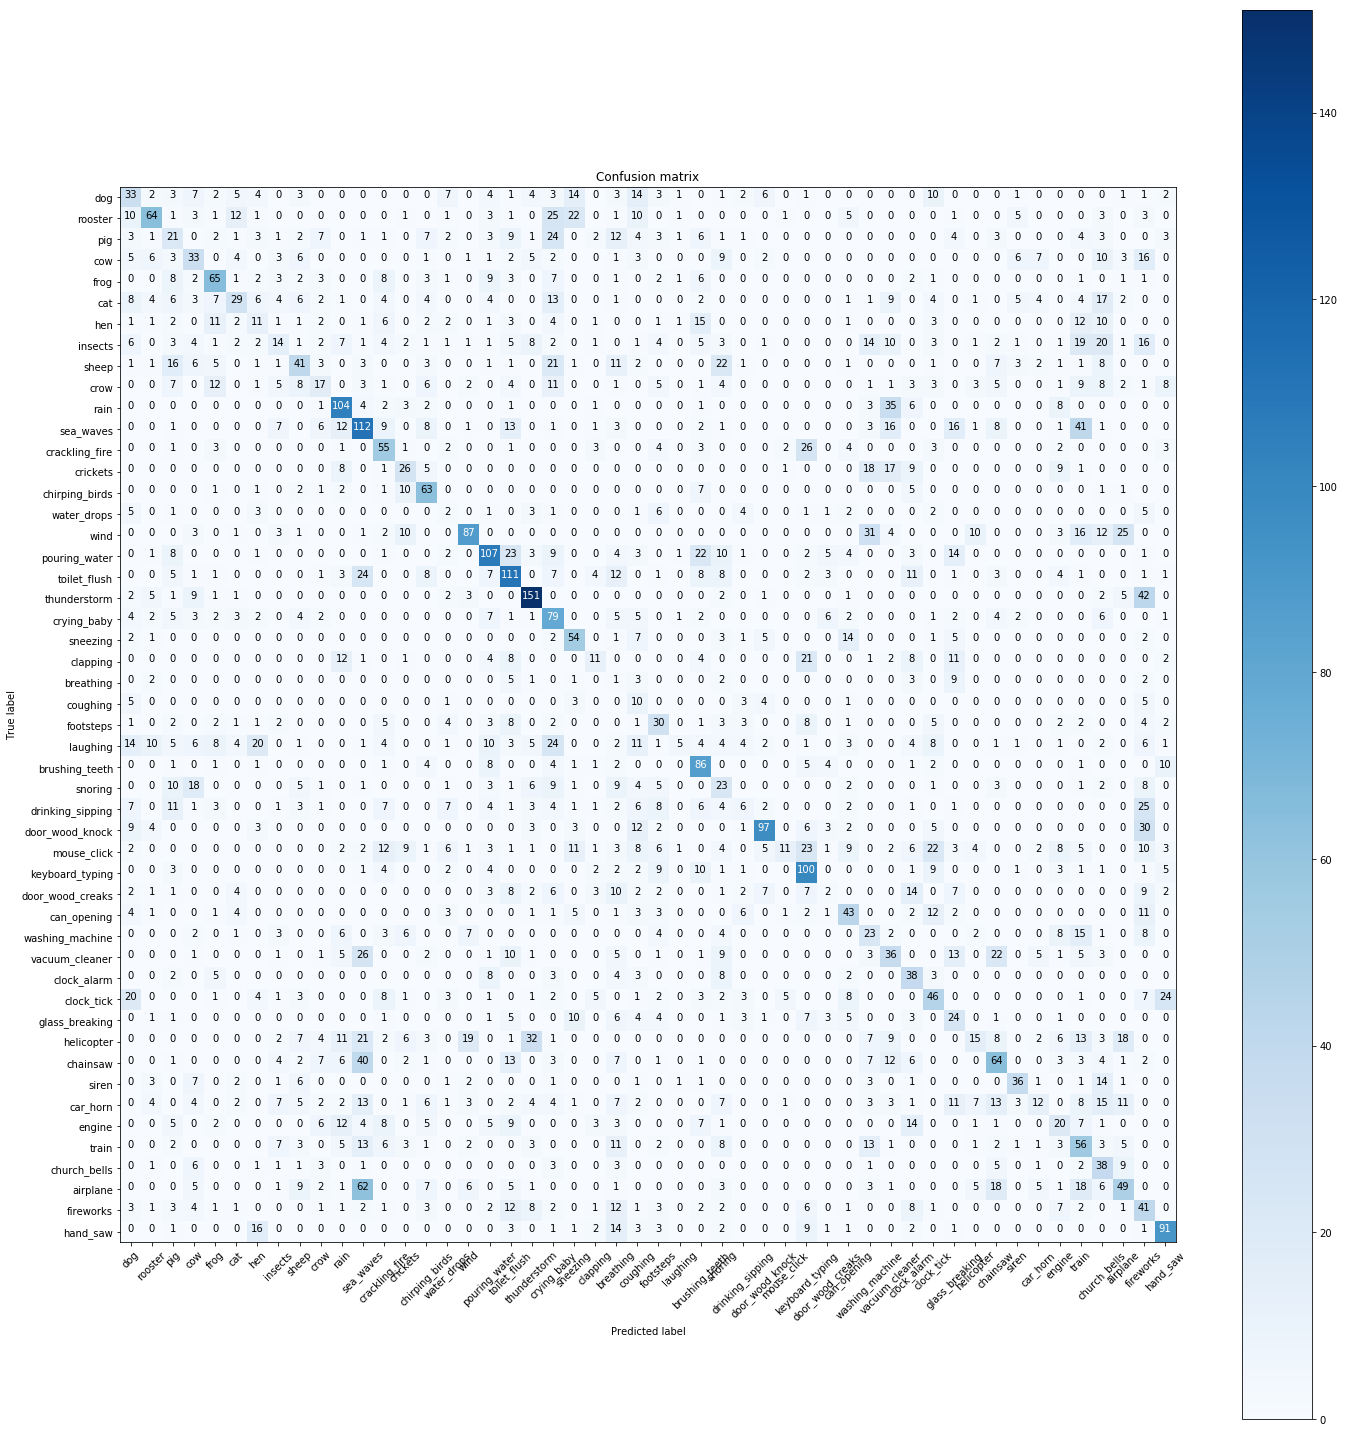

In [17]:
pred = clf.predict(test_X)
print(metrics.accuracy_score(test_yy, pred))
cm = metrics.confusion_matrix(test_yy, pred)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()

In [18]:
predictions = []
full_targets = []
start_time = time.time()
pred_probs = []

for data_iloc in range(0,2000):
    s_time = time.time()
    x_file = ps.preprocess_file(dataset.iloc[data_iloc].filename,
                                                 blocksize=blocksize,
                                                 overlap=overlap)
    y_file = dataset.iloc[data_iloc].h_target
    yy_file = dataset.iloc[data_iloc].target
    
    pred = clf.predict(x_file, verbose=0)
    pred_probs.append(clf.predict_proba(x_file))
    b = Counter(pred)
    predictions.append(b.most_common(1)[0][0])
    
    full_targets.append(yy_file)
    print("\tFile Time: " + str(time.time() - s_time))

print("\tProcessing Time: " + str(time.time() - start_time))



Epoch 1/1
2/2 [==============================] - 0s 53ms/step - loss: 1.3299
	File Time: 0.7218921184539795
	File Time: 0.520514726638794
	File Time: 0.5481054782867432
	File Time: 0.5519399642944336
	File Time: 0.4856679439544678
	File Time: 0.4330010414123535
	File Time: 0.3208434581756592
	File Time: 0.5512609481811523
	File Time: 0.5629608631134033
	File Time: 0.19538497924804688
	File Time: 0.20740032196044922
	File Time: 0.5557682514190674
	File Time: 0.5201606750488281
	File Time: 0.5887649059295654
	File Time: 0.10979843139648438
	File Time: 0.5424180030822754
	File Time: 0.5037631988525391
	File Time: 0.4735996723175049
	File Time: 0.5269832611083984
	File Time: 0.5714020729064941
	File Time: 0.5736587047576904
	File Time: 0.5213766098022461
	File Time: 0.4775276184082031
	File Time: 0.4876830577850342
	File Time: 0.41653895378112793
	File Time: 0.5139153003692627
	File Time: 0.4706249237060547
	File Time: 0.48177480697631836
	File Time: 0.5191309452056885
	File Time: 0.475353

	File Time: 0.2540261745452881
	File Time: 0.4195680618286133
	File Time: 0.4215531349182129
	File Time: 0.40814733505249023
	File Time: 0.35018420219421387
	File Time: 0.39136171340942383
	File Time: 0.5108292102813721
	File Time: 0.46131467819213867
	File Time: 0.42328381538391113
	File Time: 0.42387890815734863
	File Time: 0.43305206298828125
	File Time: 0.49296092987060547
	File Time: 0.4333832263946533
	File Time: 0.4323594570159912
	File Time: 0.44795989990234375
	File Time: 0.44707512855529785
	File Time: 0.4463503360748291
	File Time: 0.33916568756103516
	File Time: 0.4396073818206787
	File Time: 0.2858431339263916
	File Time: 0.4439232349395752
	File Time: 0.3808116912841797
	File Time: 0.3139302730560303
	File Time: 0.42435646057128906
	File Time: 0.44949960708618164
	File Time: 0.42139649391174316
	File Time: 0.4459116458892822
	File Time: 0.4023871421813965
	File Time: 0.24135327339172363
	File Time: 0.3341193199157715
	File Time: 0.40134263038635254
	File Time: 0.450301885

	File Time: 0.6337623596191406
	File Time: 0.428408145904541
	File Time: 0.42191243171691895
	File Time: 0.4158041477203369
	File Time: 0.5441231727600098
	File Time: 0.5190908908843994
	File Time: 0.5195314884185791
	File Time: 0.5947976112365723
	File Time: 0.5129761695861816
	File Time: 0.5490903854370117
	File Time: 0.5138523578643799
	File Time: 0.511920690536499
	File Time: 0.457103967666626
	File Time: 0.42357754707336426
	File Time: 0.4232456684112549
	File Time: 0.25286245346069336
	File Time: 0.4222447872161865
	File Time: 0.45934534072875977
	File Time: 0.4925379753112793
	File Time: 0.5200028419494629
	File Time: 0.18605256080627441
	File Time: 0.45050573348999023
	File Time: 0.16944408416748047
	File Time: 0.35898804664611816
	File Time: 0.42135095596313477
	File Time: 0.4735276699066162
	File Time: 0.5027363300323486
	File Time: 0.46350955963134766
	File Time: 0.18687200546264648
	File Time: 0.2291269302368164
	File Time: 0.42633771896362305
	File Time: 0.2508542537689209

	File Time: 0.4309353828430176
	File Time: 0.422443151473999
	File Time: 0.5116629600524902
	File Time: 0.481553316116333
	File Time: 0.2651970386505127
	File Time: 0.5026750564575195
	File Time: 0.4295964241027832
	File Time: 0.2720038890838623
	File Time: 0.13924884796142578
	File Time: 0.42570996284484863
	File Time: 0.444843053817749
	File Time: 0.4282562732696533
	File Time: 0.4305577278137207
	File Time: 0.431318998336792
	File Time: 0.4334897994995117
	File Time: 0.43908238410949707
	File Time: 0.44957995414733887
	File Time: 0.4773263931274414
	File Time: 0.5658848285675049
	File Time: 0.5523631572723389
	File Time: 0.5143048763275146
	File Time: 0.5001685619354248
	File Time: 0.5453259944915771
	File Time: 0.48652100563049316
	File Time: 0.5258467197418213
	File Time: 0.4717700481414795
	File Time: 0.47732067108154297
	File Time: 0.49125075340270996
	File Time: 0.4674222469329834
	File Time: 0.5255694389343262
	File Time: 0.4789762496948242
	File Time: 0.4110596179962158
	File

	File Time: 0.5135486125946045
	File Time: 0.2668783664703369
	File Time: 0.5229349136352539
	File Time: 0.31267881393432617
	File Time: 0.5174944400787354
	File Time: 0.5808901786804199
	File Time: 0.5265815258026123
	File Time: 0.5442440509796143
	File Time: 0.4960672855377197
	File Time: 0.534428596496582
	File Time: 0.5544238090515137
	File Time: 0.5142545700073242
	File Time: 0.4611642360687256
	File Time: 0.5438113212585449
	File Time: 0.5412299633026123
	File Time: 0.48047661781311035
	File Time: 0.41452622413635254
	File Time: 0.5237374305725098
	File Time: 0.14799714088439941
	File Time: 0.5354058742523193
	File Time: 0.4736180305480957
	File Time: 0.5231688022613525
	File Time: 0.47400617599487305
	File Time: 0.24955081939697266
	File Time: 0.18343257904052734
	File Time: 0.42171287536621094
	File Time: 0.5626285076141357
	File Time: 0.4997408390045166
	File Time: 0.46404433250427246
	File Time: 0.4122800827026367
	File Time: 0.41556596755981445
	File Time: 0.4152476787567138

	File Time: 0.5091352462768555
	File Time: 0.4697716236114502
	File Time: 0.4219033718109131
	File Time: 0.42365193367004395
	File Time: 0.4618868827819824
	File Time: 0.5114686489105225
	File Time: 0.5214605331420898
	File Time: 0.4107649326324463
	File Time: 0.3422062397003174
	File Time: 0.36463403701782227
	File Time: 0.5406618118286133
	File Time: 0.5278191566467285
	File Time: 0.49158453941345215
	File Time: 0.37473440170288086
	File Time: 0.380023717880249
	File Time: 0.4840128421783447
	File Time: 0.4189717769622803
	File Time: 0.41031670570373535
	File Time: 0.4174642562866211
	File Time: 0.410369873046875
	File Time: 0.5316815376281738
	File Time: 0.47263622283935547
	File Time: 0.46526622772216797
	File Time: 0.5117988586425781
	File Time: 0.5339651107788086
	File Time: 0.5504782199859619
	File Time: 0.4770512580871582
	File Time: 0.41688084602355957
	File Time: 0.4578135013580322
	File Time: 0.49916911125183105
	File Time: 0.46291661262512207
	File Time: 0.5744566917419434


	File Time: 0.4552755355834961
	File Time: 0.4970846176147461
	File Time: 0.48976778984069824
	File Time: 0.4203224182128906
	File Time: 0.4251546859741211
	File Time: 0.42367100715637207
	File Time: 0.4739961624145508
	File Time: 0.48856687545776367
	File Time: 0.5308511257171631
	File Time: 0.47448039054870605
	File Time: 0.510479211807251
	File Time: 0.4490969181060791
	File Time: 0.4140512943267822
	File Time: 0.4395620822906494
	File Time: 0.35326695442199707
	File Time: 0.4199669361114502
	File Time: 0.2972092628479004
	File Time: 0.45267510414123535
	File Time: 0.48377418518066406
	File Time: 0.4479100704193115
	File Time: 0.44468212127685547
	File Time: 0.5421879291534424
	File Time: 0.5231258869171143
	File Time: 0.5443809032440186
	File Time: 0.4765782356262207
	File Time: 0.41692423820495605
	File Time: 0.4181509017944336
	File Time: 0.45858287811279297
	File Time: 0.19807219505310059
	File Time: 0.30267786979675293
	File Time: 0.11437869071960449
	File Time: 0.4709486961364

	File Time: 0.42538928985595703
	File Time: 0.42478299140930176
	File Time: 0.42227745056152344
	File Time: 0.22863125801086426
	File Time: 0.18300437927246094
	File Time: 0.18382954597473145
	File Time: 0.5207581520080566
	File Time: 0.5090305805206299
	File Time: 0.4779703617095947
	File Time: 0.5533871650695801
	File Time: 0.4966309070587158
	File Time: 0.43973708152770996
	File Time: 0.41136765480041504
	File Time: 0.5653190612792969
	File Time: 0.39186930656433105
	File Time: 0.2723867893218994
	File Time: 0.263228178024292
	File Time: 0.5189728736877441
	File Time: 0.4664325714111328
	File Time: 0.1891944408416748
	File Time: 0.2660975456237793
	File Time: 0.5306243896484375
	File Time: 0.47124218940734863
	File Time: 0.11564874649047852
	File Time: 0.3737645149230957
	File Time: 0.41819214820861816
	File Time: 0.4181852340698242
	File Time: 0.5535309314727783
	File Time: 0.5400722026824951
	File Time: 0.5375931262969971
	File Time: 0.5360612869262695
	File Time: 0.52039456367492

In [19]:
targs = np.vstack(full_targets)

0.62
Confusion matrix, without normalization
[[28  0  0 ...  0  0  0]
 [ 0 31  0 ...  0  0  0]
 [ 0  0 26 ...  0  1  0]
 ...
 [ 0  0  0 ... 24  0  0]
 [ 0  0  0 ...  0 26  0]
 [ 0  0  0 ...  0  0 31]]


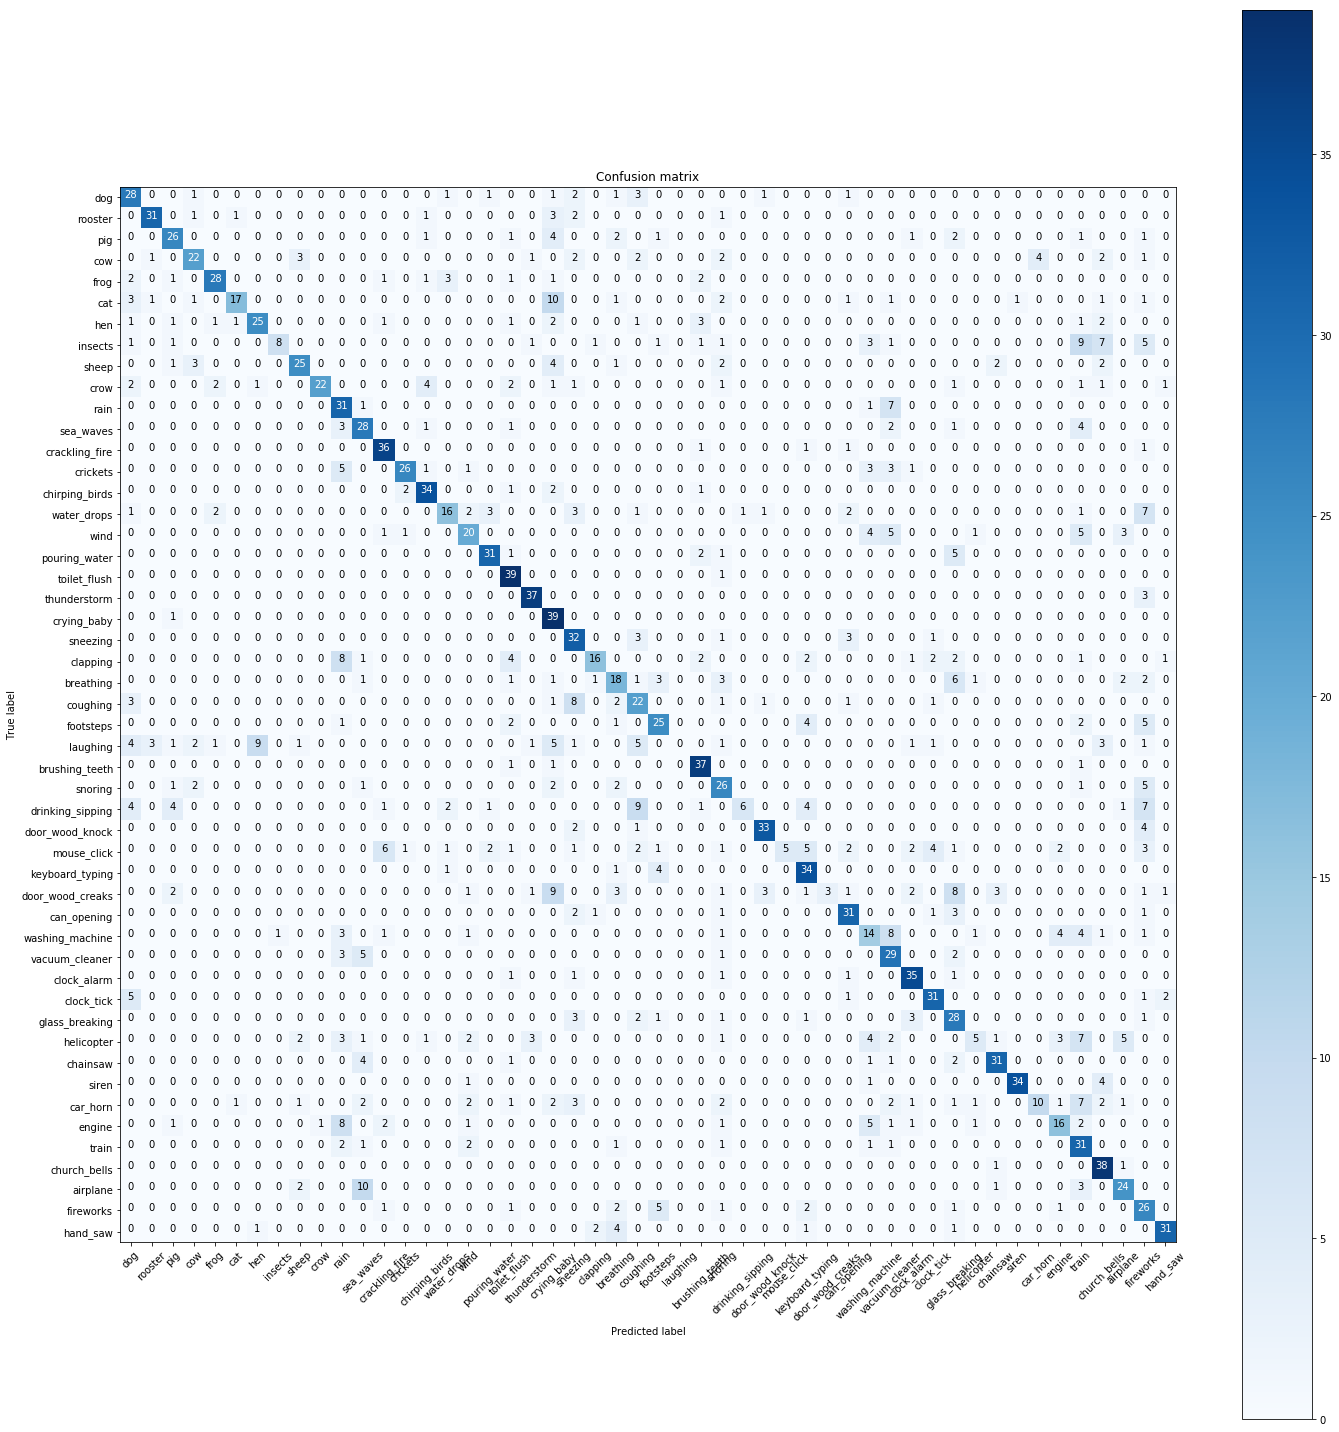

In [20]:
print(metrics.accuracy_score(full_targets, predictions))
cm = metrics.confusion_matrix(full_targets, predictions)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()

In [21]:
t_df = ps.preprocess_fold(dataset, 
                        kind='mfcc', 
                        blocksize=blocksize, 
                        overlap=overlap,
                        feature_bag=False
                       )
t_df.head()

,target,h_target,metadata
0,0,0,mfcc_2_std mfcc_2_mean mfcc_2_noise mfcc...
1,14,0,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...
2,36,1,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...
3,36,1,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...
4,19,1,mfcc_2_std mfcc_2_mean mfcc_2_noise mfc...


In [37]:
%%time

predictions = []
full_targets = []
start_time = time.time()
pred_probs = []
time_per_file = []

for data_iloc in range(0,2000):
    s_time = time.time()
    x_file = t_df.iloc[data_iloc].metadata

    y_file = dataset.iloc[data_iloc].h_target
    yy_file = dataset.iloc[data_iloc].target
    
    pred = clf.predict(x_file, verbose=0)
    b = Counter(pred)
    predictions.append(b.most_common(1)[0][0])
    
    full_targets.append(yy_file)
    time_per_file.append(time.time() - s_time)
    print("\tFile Time: " + str(time.time() - s_time))

print("\tAverage File Time: " + str(np.average(time_per_file)))
print("\tProcessing Time: " + str(time.time() - start_time))

	File Time: 0.007309436798095703
	File Time: 0.005877494812011719
	File Time: 0.005541801452636719
	File Time: 0.005409955978393555
	File Time: 0.005249977111816406
	File Time: 0.0038933753967285156
	File Time: 0.004761934280395508
	File Time: 0.004578590393066406
	File Time: 0.004572391510009766
	File Time: 0.004762172698974609
	File Time: 0.004271268844604492
	File Time: 0.004373788833618164
	File Time: 0.0043697357177734375
	File Time: 0.004846334457397461
	File Time: 0.003927946090698242
	File Time: 0.004097938537597656
	File Time: 0.0040514469146728516
	File Time: 0.004258632659912109
	File Time: 0.0054285526275634766
	File Time: 0.0048558712005615234
	File Time: 0.0051174163818359375
	File Time: 0.004652261734008789
	File Time: 0.004512310028076172
	File Time: 0.004938840866088867
	File Time: 0.00851893424987793
	File Time: 0.005405426025390625
	File Time: 0.0055522918701171875
	File Time: 0.005434751510620117
	File Time: 0.005466938018798828
	File Time: 0.005395412445068359
	Fil

	File Time: 0.0036284923553466797
	File Time: 0.003129720687866211
	File Time: 0.003014802932739258
	File Time: 0.0029914379119873047
	File Time: 0.0029573440551757812
	File Time: 0.0029249191284179688
	File Time: 0.002959728240966797
	File Time: 0.0029294490814208984
	File Time: 0.002931356430053711
	File Time: 0.0029342174530029297
	File Time: 0.0029523372650146484
	File Time: 0.0029315948486328125
	File Time: 0.0029234886169433594
	File Time: 0.002914905548095703
	File Time: 0.002972841262817383
	File Time: 0.002855539321899414
	File Time: 0.002839326858520508
	File Time: 0.002820253372192383
	File Time: 0.0029480457305908203
	File Time: 0.002951383590698242
	File Time: 0.002932310104370117
	File Time: 0.00287628173828125
	File Time: 0.002965688705444336
	File Time: 0.0028600692749023438
	File Time: 0.0029497146606445312
	File Time: 0.002930879592895508
	File Time: 0.0028908252716064453
	File Time: 0.002862215042114258
	File Time: 0.0029006004333496094
	File Time: 0.0028614997863769

	File Time: 0.003656148910522461
	File Time: 0.0034477710723876953
	File Time: 0.003130197525024414
	File Time: 0.0030717849731445312
	File Time: 0.003102540969848633
	File Time: 0.003107786178588867
	File Time: 0.003075122833251953
	File Time: 0.0031235218048095703
	File Time: 0.0031023025512695312
	File Time: 0.0030517578125
	File Time: 0.0029740333557128906
	File Time: 0.002988576889038086
	File Time: 0.0030236244201660156
	File Time: 0.0030307769775390625
	File Time: 0.0029973983764648438
	File Time: 0.0028951168060302734
	File Time: 0.003020763397216797
	File Time: 0.0030202865600585938
	File Time: 0.0030202865600585938
	File Time: 0.0028765201568603516
	File Time: 0.0030210018157958984
	File Time: 0.0030164718627929688
	File Time: 0.0029964447021484375
	File Time: 0.003008604049682617
	File Time: 0.002927541732788086
	File Time: 0.002982616424560547
	File Time: 0.003042459487915039
	File Time: 0.002974987030029297
	File Time: 0.002988576889038086
	File Time: 0.0029754638671875
	F

	File Time: 0.003262042999267578
	File Time: 0.0030891895294189453
	File Time: 0.0029675960540771484
	File Time: 0.0029799938201904297
	File Time: 0.0029659271240234375
	File Time: 0.0029735565185546875
	File Time: 0.0029730796813964844
	File Time: 0.004620075225830078
	File Time: 0.004334926605224609
	File Time: 0.006016254425048828
	File Time: 0.004958391189575195
	File Time: 0.0048100948333740234
	File Time: 0.0048830509185791016
	File Time: 0.004942417144775391
	File Time: 0.004848957061767578
	File Time: 0.005104541778564453
	File Time: 0.004762887954711914
	File Time: 0.004457235336303711
	File Time: 0.004863739013671875
	File Time: 0.00526881217956543
	File Time: 0.005164384841918945
	File Time: 0.004726886749267578
	File Time: 0.0048329830169677734
	File Time: 0.004604816436767578
	File Time: 0.00468134880065918
	File Time: 0.004704475402832031
	File Time: 0.004407167434692383
	File Time: 0.004418134689331055
	File Time: 0.004324436187744141
	File Time: 0.004118680953979492
	Fi

	File Time: 0.0032651424407958984
	File Time: 0.0031363964080810547
	File Time: 0.0029468536376953125
	File Time: 0.002938985824584961
	File Time: 0.0030617713928222656
	File Time: 0.0029687881469726562
	File Time: 0.0029706954956054688
	File Time: 0.002934694290161133
	File Time: 0.002869844436645508
	File Time: 0.0029535293579101562
	File Time: 0.002887725830078125
	File Time: 0.002943277359008789
	File Time: 0.002984762191772461
	File Time: 0.0029778480529785156
	File Time: 0.002971172332763672
	File Time: 0.0029714107513427734
	File Time: 0.0027763843536376953
	File Time: 0.0027875900268554688
	File Time: 0.0028116703033447266
	File Time: 0.0027878284454345703
	File Time: 0.002768278121948242
	File Time: 0.0030820369720458984
	File Time: 0.002982616424560547
	File Time: 0.0027990341186523438
	File Time: 0.0028324127197265625
	File Time: 0.002813100814819336
	File Time: 0.002829313278198242
	File Time: 0.0028901100158691406
	File Time: 0.0028374195098876953
	File Time: 0.00311112403

	File Time: 0.002682209014892578
	File Time: 0.0031921863555908203
	File Time: 0.002889394760131836
	File Time: 0.0027129650115966797
	File Time: 0.002729654312133789
	File Time: 0.002644777297973633
	File Time: 0.0026874542236328125
	File Time: 0.0027031898498535156
	File Time: 0.002618551254272461
	File Time: 0.002685070037841797
	File Time: 0.0026345252990722656
	File Time: 0.0025832653045654297
	File Time: 0.002681732177734375
	File Time: 0.0027112960815429688
	File Time: 0.002550363540649414
	File Time: 0.0026438236236572266
	File Time: 0.0025975704193115234
	File Time: 0.0025839805603027344
	File Time: 0.002657651901245117
	File Time: 0.002582550048828125
	File Time: 0.002529621124267578
	File Time: 0.0024864673614501953
	File Time: 0.002460956573486328
	File Time: 0.0025882720947265625
	File Time: 0.0025665760040283203
	File Time: 0.002532482147216797
	File Time: 0.0025551319122314453
	File Time: 0.0024492740631103516
	File Time: 0.0026717185974121094
	File Time: 0.0026011466979

	File Time: 0.0037078857421875
	File Time: 0.0033597946166992188
	File Time: 0.0031752586364746094
	File Time: 0.003116607666015625
	File Time: 0.003153562545776367
	File Time: 0.0031845569610595703
	File Time: 0.0031423568725585938
	File Time: 0.003084897994995117
	File Time: 0.0030219554901123047
	File Time: 0.003144502639770508
	File Time: 0.0030891895294189453
	File Time: 0.0029022693634033203
	File Time: 0.002990245819091797
	File Time: 0.00299072265625
	File Time: 0.00292205810546875
	File Time: 0.002916097640991211
	File Time: 0.002918720245361328
	File Time: 0.0029134750366210938
	File Time: 0.0029408931732177734
	File Time: 0.002895832061767578
	File Time: 0.0029172897338867188
	File Time: 0.0029146671295166016
	File Time: 0.002909421920776367
	File Time: 0.002908945083618164
	File Time: 0.0029189586639404297
	File Time: 0.0028557777404785156
	File Time: 0.0028638839721679688
	File Time: 0.0029296875
	File Time: 0.002923727035522461
	File Time: 0.0029458999633789062
	File Time

	File Time: 0.004585742950439453
	File Time: 0.004157304763793945
	File Time: 0.003805398941040039
	File Time: 0.0036525726318359375
	File Time: 0.003826141357421875
	File Time: 0.0036897659301757812
	File Time: 0.0037076473236083984
	File Time: 0.003699064254760742
	File Time: 0.0034813880920410156
	File Time: 0.003459453582763672
	File Time: 0.0034830570220947266
	File Time: 0.0034410953521728516
	File Time: 0.0032758712768554688
	File Time: 0.0034644603729248047
	File Time: 0.003266572952270508
	File Time: 0.003281831741333008
	File Time: 0.0035071372985839844
	File Time: 0.0034949779510498047
	File Time: 0.0034253597259521484
	File Time: 0.0032095909118652344
	File Time: 0.004449605941772461
	File Time: 0.0049571990966796875
	File Time: 0.004675149917602539
	File Time: 0.0032501220703125
	File Time: 0.0031125545501708984
	File Time: 0.0031049251556396484
	File Time: 0.0031156539916992188
	File Time: 0.0030329227447509766
	File Time: 0.003100156784057617
	File Time: 0.00298690795898

0.662
0.7023737766539143
Confusion matrix, without normalization
[[28  1  0 ...  0  0  0]
 [ 0 31  0 ...  0  0  0]
 [ 0  0 19 ...  0  0  1]
 ...
 [ 0  0  0 ... 27  0  0]
 [ 0  0  0 ...  0 25  0]
 [ 0  0  0 ...  0  0 37]]


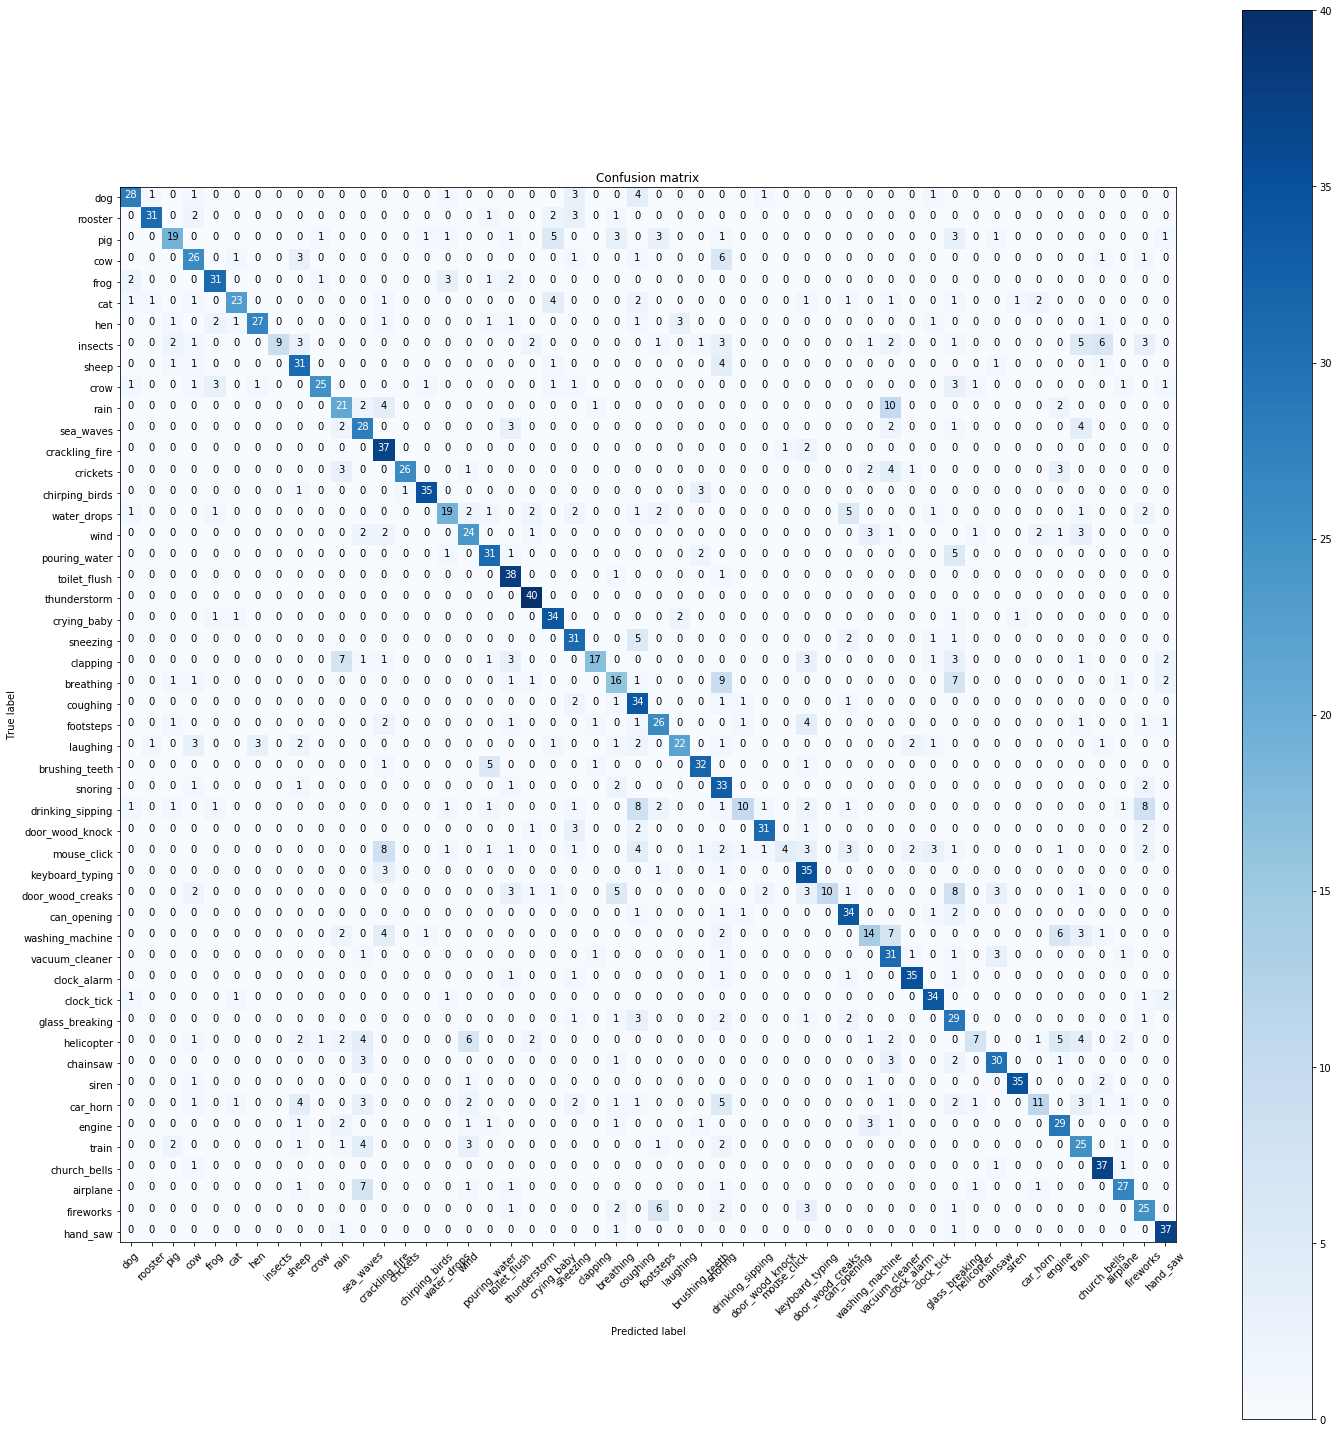

In [38]:
print(metrics.accuracy_score(full_targets, predictions))
print(metrics.precision_score(full_targets, predictions, average='macro'))
cm = metrics.confusion_matrix(full_targets, predictions)
plt.figure(figsize=(20,20))
plot_confusion_matrix(cm, classes)
plt.show()

# Cross Validation

In [24]:
%%time
from sklearn.model_selection import cross_validate

clf = Pipeline([
    ('scaler', MinMaxScaler()),
    ('feat_sel', SelectKBest(k=80, score_func=chi2)),
    ('feat_red', PCA(n_components=50)),
    ('classify', KerasClassifier(build_fn=deep_net, 
                       epochs=50, 
                       batch_size=35, 
                       verbose=0)
    )
])

scores = cross_validate(clf, train_X, train_yy, cv=5, scoring=['accuracy', 'precision_macro', 'recall_macro'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 128)               6528      
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
__________

CPU times: user 20min 18s, sys: 10min, total: 30min 19s
Wall time: 8min 30s


In [25]:
clf.fit(train_X, train_yy)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 128)               6528      
_________________________________________________________________
dropout_25 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_26 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_40 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_27 (Dropout)         (None, 64)                0         
__________

Pipeline(memory=None,
     steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('feat_sel', SelectKBest(k=80, score_func=<function chi2 at 0x7fe1cba4d378>)), ('feat_red', PCA(copy=True, iterated_power='auto', n_components=50, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('classify', <keras.wrappers.scikit_learn.KerasClassifier object at 0x7fe23448cac8>)])

In [26]:
pd.DataFrame(scores)

,fit_time,score_time,test_accuracy,test_precision_macro,test_recall_macro,train_accuracy,train_precision_macro,train_recall_macro
0,98.462831,0.697404,0.285868,0.269288,0.294267,0.538544,0.547643,0.532855
1,97.144024,0.729751,0.289100,0.278054,0.301200,0.543483,0.553933,0.539396
2,97.124873,0.756416,0.287356,0.282610,0.293932,0.530708,0.544815,0.523157
3,98.610704,0.844478,0.295438,0.282346,0.290854,0.536904,0.530633,0.529762
4,104.607238,0.871708,0.257364,0.251463,0.259110,0.557152,0.568274,0.556536


In [27]:
def query_dataset(query_term):
    h_l = mapping[query_term]
    l_l = classes.index(query_term)

    predictions = []
    test = df[df.fold == 1]

    for data_iloc in range(0,len(test)):
        x_file = test.iloc[data_iloc].metadata.drop(['h_target', 'target', 'fold'], axis=1)

        y_file = dataset.iloc[data_iloc].h_target
        yy_file = dataset.iloc[data_iloc].target

        predictions.append({
            'file': dataset.iloc[data_iloc].filename,
            'ds_id': data_iloc,
            'prob': np.average(clf.predict_proba(x_file)[:,l_l]),
            'prediction': clf.predict(x_file)
        })
    
    predictions = pd.DataFrame(predictions).sort_values(by=['prob'], ascending=False).reset_index(drop=True)
    
    return predictions

In [28]:
%%time
preds = query_dataset('dog')

CPU times: user 4.16 s, sys: 272 ms, total: 4.43 s
Wall time: 3.7 s


In [29]:
preds.head()

,ds_id,file,prediction,prob
0,91,1-19872-B-36.wav,"[26, 38, 20, 26, 29, 6, 0, 0, 6, 3, 26, 26, 0,...",0.251759
1,170,1-32318-A-0.wav,"[26, 26, 0, 26, 0]",0.223658
2,209,1-43807-A-47.wav,"[6, 6, 0, 0, 38, 30, 24, 38, 38, 38, 24, 21, 3...",0.207729
3,366,1-81883-A-21.wav,"[4, 0, 1, 1, 9, 0, 4, 0, 0, 0, 0, 4, 15, 5, 5,...",0.193271
4,109,1-21896-A-35.wav,"[38, 0, 38, 26, 26, 38, 38, 29, 26, 24, 4, 20,...",0.177623


In [33]:
# Checking index
def check_accuracy(preds, query, count):
    misclass = []
    
    print(query)
    for data_iloc in range(0, count):
        row = preds.iloc[data_iloc]
        if dataset.iloc[row.ds_id].target != classes.index(query):
            misclass.append(classes[dataset.iloc[row.ds_id].target])
            
    print(misclass)
    print()
    return (count - len(misclass))/count

In [34]:
# Checking index
check_accuracy(preds, 'dog', 10)

dog
['mouse_click', 'coughing', 'snoring', 'church_bells', 'vacuum_cleaner', 'brushing_teeth', 'airplane', 'water_drops', 'pig', 'can_opening']



0.0

In [36]:
accuracies = []
for cls in classes:
    preds = query_dataset(cls)
    acc = check_accuracy(preds, cls, 10)
    print(acc)
    accuracies.append(acc)
    
np.average(accuracies)

dog
['vacuum_cleaner', 'airplane', 'sneezing', 'washing_machine', 'chirping_birds', 'helicopter', 'train', 'crackling_fire', 'crickets']

0.1
rooster
['siren', 'siren', 'laughing', 'hen', 'airplane', 'crow', 'dog', 'chainsaw', 'cat', 'crow']

0.0
pig
['thunderstorm', 'cat', 'footsteps', 'wind', 'insects', 'church_bells', 'thunderstorm', 'cat', 'keyboard_typing', 'sheep']

0.0
cow
['engine', 'clapping', 'can_opening', 'rain', 'washing_machine', 'church_bells', 'hen', 'engine', 'rain', 'snoring']

0.0
frog
['washing_machine', 'fireworks', 'washing_machine', 'coughing', 'water_drops', 'sneezing', 'keyboard_typing', 'engine', 'pouring_water', 'helicopter']

0.0
cat
['crickets', 'rooster', 'wind', 'thunderstorm', 'sneezing', 'laughing', 'crow', 'hen', 'footsteps', 'can_opening']

0.0
hen
['pig', 'car_horn', 'pouring_water', 'sneezing', 'crickets', 'vacuum_cleaner', 'crow', 'vacuum_cleaner', 'pouring_water', 'keyboard_typing']

0.0
insects
['washing_machine', 'drinking_sipping', 'crying_baby

0.022000000000000002